In [82]:
import os
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn 

In [2]:
names = open("./names.txt", "r+").read().splitlines()

In [3]:
chars = sorted(list(set("".join(names))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}

In [4]:
block_size = 5

X, Y = [], []

for name in names:
    context = [0] * block_size
    for c in name + ".":
        ix = stoi[c]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]        

X = torch.tensor(X)
Y = torch.tensor(Y)

In [5]:
def build_dataset(names):

    X, Y = [], []
    
    for name in names:
        context = [0] * block_size
        for c in name + ".":
            ix = stoi[c]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]        
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(names)
n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))
Xtr, Ytr = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xtest, Ytest = build_dataset(names[n2:])

In [75]:
import torch.nn.functional as F
embed_size = 10 #embedding size
vocab_size = len(stoi) # vocabulary size
n = Y.shape[0] # the number of examples
h_size = 100 # dimension of the hidden layer
lr = 0.01
C = torch.randn((vocab_size, embed_size))
W1 = torch.randn((block_size * embed_size, h_size)) * (5/3) / ((block_size * embed_size))**0.5 #kaiming init
b1 = torch.randn(h_size) * 0.01
W2 = torch.randn((h_size, vocab_size)) * 0.01
b2 = torch.randn(vocab_size) * 0
bnbias = torch.zeros((1, h_size)) # batch norm bias
bngain = torch.ones((1, h_size)) # batch norm gain
bnmean_running = torch.zeros((1, h_size))
bnstd_running = torch.ones((1, h_size))


params = [C, W1, b1, W2, b2, bnbias, bngain]

In [76]:
for p in params:
    p.requires_grad = True

In [78]:
stepis = []
lossi = []

for i in tqdm(range(200000)):
    ix = torch.randint(0, Xtr.shape[0], (32, )) # minibatch idx
    X_batch = Xtr[ix]
    Y_batch = Ytr[ix]
    # Forward
    E = C[X_batch]
    preact = E.view(-1, block_size * embed_size) @ W1 + b1
    # batch norm 
    bnbiasi = preact.mean(axis=0, keepdim=True)
    bnstdi = preact.std(axis=0, keepdims=True)
    preact = bngain * (preact - bnbiasi) / bnstdi + bnbias
    h = torch.tanh(preact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_batch)

    with torch.no_grad():
        bnmean_running = bnmean_running * 0.999 + 0.001 * bnbiasi
        bnstd_running = bnstd_running * 0.999 + 0.001 * bnstdi

    for p in params:
        p.grad = None # zero grad
    loss.backward() # backward pass
    lr = 0.1 if i < 150000 else 0.01
    for p in params:
        p.data -= 0.1 * p.grad
    stepis.append(i)
    lossi.append(loss.log10().item())
print(loss.item())

100%|████████████████████| 200000/200000 [03:07<00:00, 1067.84it/s]

1.6754498481750488


In [84]:
embed = nn.Embedding(10, 10)
embed(torch.tensor(3))

tensor([-1.0526,  0.0955, -0.3726,  1.1867, -0.1083, -0.9715,  0.7495,  0.7358,
         0.1314,  1.2050], grad_fn=<EmbeddingBackward0>)

### Pytorch

In [108]:
# pytorch

# 
class Makemore(nn.Module):

    def __init__(self, vocab_size, embed_size, hidden_size, block_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.block_size = block_size
        self.embeddings = nn.Embedding(vocab_size, embed_size)
        self.linear1 = nn.Linear(embed_size * block_size, hidden_size, bias=False)
        self.act = nn.Tanh()
        self.batchnorm = nn.BatchNorm1d(hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)
        

    def forward(self, X):
        Z = self.embeddings(X)
        Z = self.linear1(Z.view(-1, self.block_size * self.embed_size))
        Z = self.batchnorm(Z)
        Z = self.act(Z)
        Z = self.linear2(Z)
        return Z


model = Makemore(vocab_size=vocab_size,embed_size=embed_size,hidden_size=h_size, block_size=block_size)

# training loop
model.train()
for i in tqdm(range(200000)):
    ix = torch.randint(0, Xtr.shape[0], (32, )) # minibatch idx
    X_batch = Xtr[ix]
    Y_batch = Ytr[ix]
    # Forward
    logits = model(X_batch)
    loss = F.cross_entropy(logits, Y_batch)

    for p in model.parameters():
        p.grad = None # zero grad
    loss.backward() # backward pass
    lr = 0.1 if i < 150000 else 0.01
    for p in model.parameters():
        p.data -= 0.1 * p.grad
    stepis.append(i)
    lossi.append(loss.log10().item())

100%|████████████████████| 200000/200000 [02:43<00:00, 1225.66it/s]


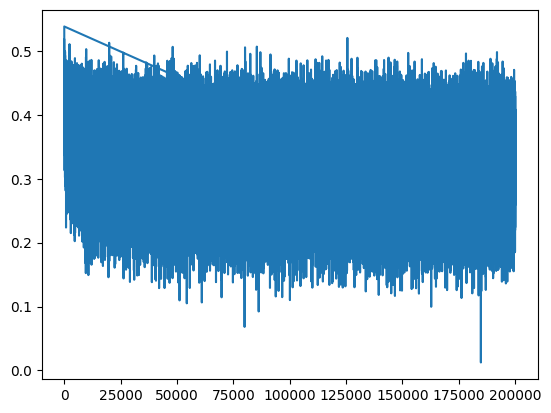

In [109]:
plt.plot(stepis, lossi)

In [112]:
# pytorch eval code
model.eval()
@torch.no_grad()
def split_loss(split):
    x, y = {"train": (Xtr, Ytr), "dev": (Xdev, Ydev), "test": (Xtest, Ytest)}[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    return loss.item() # total loss
    

In [116]:
split_loss("train")

2.0680458545684814

In [25]:
logits[0]

tensor([-13.2262,  10.0456, -11.1457,   4.6879,  10.9535,  -2.1740, -10.1629,
          0.6027,   8.6200,   9.4202,  -1.0639,   5.1765,  -6.2587,  -0.1037,
         -1.0372,  14.1808,   4.6826, -16.1674,  -8.7546,   7.3978,  -0.6505,
          9.5422,  -2.2976,  -2.6281,  -5.1374, -10.4111,  14.0705],
       grad_fn=<SelectBackward0>)

In [80]:
@torch.no_grad()
def split_loss(split):
    x, y = {"train": (Xtr, Ytr), "dev": (Xdev, Ydev), "test": (Xtest, Ytest)}[split]
    E = C[x]
    preact = E.view(-1, block_size * embed_size) @ W1 + b1
    preact = bngain * (preact - bngain_running) / bnstd_running + bnbias
    h = torch.tanh(preact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    return loss.item() # total loss

In [81]:
print(split_loss("train"))
print(split_loss("dev"))

2.4790005683898926
2.500147819519043


In [60]:
# sampling

In [113]:
def sample():
    context = [0] * block_size
    context = context
    res = ""
    while True:
        E = C[context]
        h = E.view(-1, block_size * embed_size) @ W1 + b1
        h = torch.tanh(h)
        logits = h @ W2 + b2
        probs = F.softmax(logits)
        ix = torch.multinomial(probs, num_samples=1).item()
        if ix == 0:
            break
        res += itos[ix]
        context = context[1:] + [ix]
    return res

In [122]:
sample()

/var/folders/yw/_q0c7_715496fszpj84k_tb00000gn/T/ipykernel_90696/159107022.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(logits)


'roris'

In [119]:
from abc import ABC, abstractmethod

class Module(ABC):

    @abstractmethod
    def __call__(self, X):
        pass

    @abstractmethod
    def parameters(self):
        pass


class Linear(Module):

    def __init__(din, dout, bias=True):
        self.W = torch.randn((din, dout)) / (din ** 0.5)
        self.b = torch.zeros((1, dout)) if bias else None

    def __call__(self, X):
        out = X @ self.W
        if self.b is not None:
            out += self.b
        return out

    def parameters(self):
        return [self.W] + ([] if self.b is None else [self.b])


class BatchNorm1D(Module):

    def __init__(dim, momentum=0.1, eps=1e-5):
        self.train = True
        self.momentum = momentum
        self.eps = eps
        self.gamma = torch.ones((1, dim)) 
        self.beta = torch.zeros((1, dim))
        self.running_mean = torch.zeros((1, dim))
        self.running_var = torch.ones((1, dim))

    def __call__(X):
        if not self.train: # we are using the evaluated parameters
            out = self.gamma * (X - self.running_mean) / torch.sqrt(self.running_var + self.eps)  + self.beta
            return out
        batch_mean = X.mean(axis=0, keep_dims=True)
        batch_var = X.var(axis=0, keep_dims=True)
        if self.train:
            with torch.no_grad():
                self.running_mean = self.running_mean * (1 - self.momentum) + batch_mean * self.momentum
                self.running_var = self.running_var * (1 - self.momentum) + batch_var * self.momentum
        out = self.gamma * (X - batch_mean) / torch.sqrt(batch_var + self.eps) + self.beta
        return out

    def parameters(self):
        return [self.beta, self.gamma]

class Tanh(Module):

    def __call__(self, X):
        out = torch.tanh(X)
        return out

    def parameters(self):
        return []
